In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

In [23]:
class Learner(object):
    def __init__(self, state, loss):
        self.state = state
        self.loss = loss

    def load_confirmed(self, state):
      """
      Load confirmed cases downloaded from HDX
      """
      df = pd.read_csv('data/correct-state-cases.csv')
      
      for i in range(len(df)-1):
        df.iloc[i+1] = df.iloc[i] + df.iloc[i+1]
      
      
      state_df = alpha * df[state]
#       print(state_df.astype(int))
      return state_df.astype(int)



    def predict(self, beta, gamma, data):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        predict_range = 150
        size = len(data)
        
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
          
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return extended_actual, solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1))

    def train(self):
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        data = self.load_confirmed(self.state)
        
        optimal = minimize(
            loss,
            [0.0001, 0.0001],
            args=(data),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        
        
        beta, gamma = optimal.x
        
        
        return optimal.fun, beta, gamma

In [24]:
def loss(point, data):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    """
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

In [28]:
learner = Learner("Georgia", loss)


minm = float('inf')
best_alpha = -1
best_beta = -1
best_gamma = -1

for alpha in np.arange(0.1,1,0.2):

  S_0 = int(226180*alpha)
  I_0 = 2
  R_0 = 0
  fn, beta, gamma = learner.train()
  if(fn < minm):
    minm = fn
    best_alpha = alpha
    best_beta = beta
    best_gamma = gamma
    

print("alpha:", best_alpha)
print("beat:", best_beta)
print("gamma:", best_gamma)

alpha: 0.1
beat: 5.5611221822097535e-06
gamma: 8.766554701949887e-05


0          1
1          1
2          1
3          1
4          2
       ...  
87    201409
88    201881
89    202284
90    202928
91    203563
Name: Georgia, Length: 92, dtype: int32


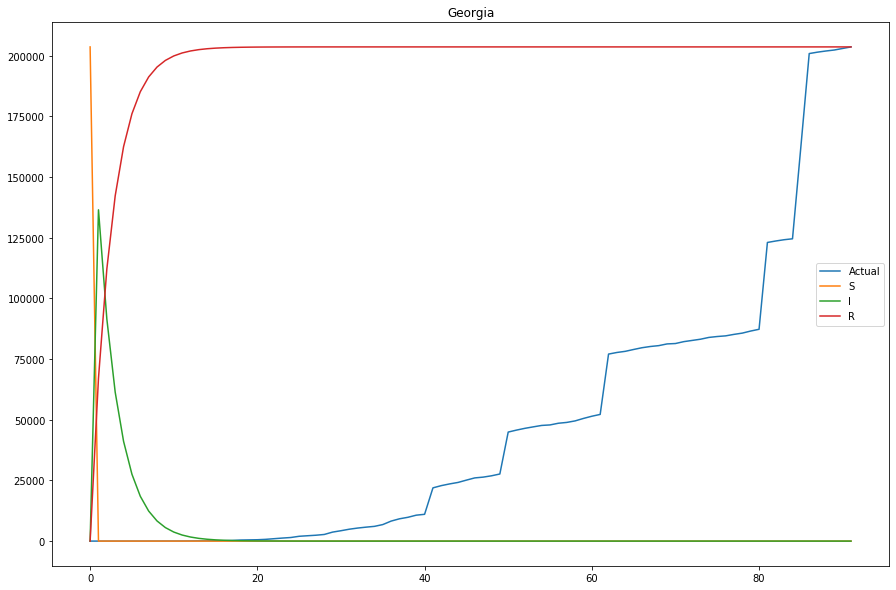

In [29]:
state = "Georgia"

data = learner.load_confirmed(state)

print(data)

extended_actual, prediction = learner.predict(beta, gamma, data)
df = pd.DataFrame({
    'Actual': extended_actual,
    'S': prediction.y[0],
    'I': prediction.y[1],
    'R': prediction.y[2]
})
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title(state)
df.plot(ax=ax)
fig.savefig(f"{state}.png")